In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import credentials
import requests
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from pandas import DataFrame
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
import datetime as dt


#pulling data API

key =credentials.login['key_isaham']  # extract password

In [2]:
# looping through all stocks

def strategy_label(wl):
    
    ori_data = {}
    all_ori_stocks = []
    # Scale dictionary of dataframes for training set(scaling by stock)
    ss={}
    d = {}

    # Scale dictionary of dataframes for prediction set(scaling by stock)
    sp={}
    nsp={}

    for m,stock in enumerate (wl):

        #print("----------------PROCESSING {}------------------".format(stock))
        symbol = stock    # Which stock to pull    
        response = requests.get("https://admin.isaham.my/api/chart?stock={}&key={}".format(symbol,key))
        data = response.json()

        ori = pd.DataFrame.from_dict(data)
        ori = ori[['c','d','h','l','o','v']]
        ori['d'] = pd.to_datetime(ori['d'], dayfirst= True )
        # adding the stock names
        ori["Stock"] = stock
        ori_data[f"{symbol}"] = ori
        all_ori_stocks.append(ori_data[stock])
        
        df = ori.reset_index(drop=False)
        
        
        # Tuning OB and OS level
        ob_cross=85
        os_cross=35
        
        # Identify MA50
        n=50
        ma50=[] 

        for i in range(len(df["c"])-(n-1)):
            ma = round(sum(df["c"][i:i+(n)])/n,4)
            ma50.append(ma)

        df["MA50"] = pd.Series(ma50)
        df["MA50"] = df["MA50"].shift(n-1)

        # Filter uptrend price above ma50
        # Calculating the gap of both MA
        df["MAgap"] = df["c"] -  df["MA50"] 

        # Set date as index
        df.set_index('d',inplace=True,drop=False)
        df.index.name = None

        # Create signal for uptrend price above ma50 
        # Result not accurate for stochastic when just filter uptrend only
        df["Uptrend"]=df['MAgap']>0
        Uptrend=df["Uptrend"]
        Uptrend_signal=Uptrend[Uptrend==True]

        # Signal stochastic
        # Create the "L14" column in the DataFrame
        df['L14'] = df['l'].rolling(window=14).min()

        # Create the "H14" column in the DataFrame
        df['H14'] = df['h'].rolling(window=14).max()

        # Create the "%K" column in the DataFrame
        df['%K'] = 100*((df['c'] - df['L14']) / (df['H14'] - df['L14']) )

        # Create the "%D" column in the DataFrame
        df['%D'] = df['%K'].rolling(window=3).mean()

        # Create a column in the DataFrame showing "TRUE" if buy entry signal is given and "FALSE" otherwise. 
        # A buy is initiated when the %K line crosses up through the %D line and the value of the oscillator is below 20 
        df['Buy OS'] = ((df['%K'] > df['%D']) & (df['%K'].shift(1) < df['%D'].shift(1))) & (df['%D'] < os_cross) & (Uptrend_signal)

        # Create a column in the DataFrame showing "TRUE" if sell entry signal is given and "FALSE" otherwise. 
        # A sell is initiated when the %K line crosses down through the %D line and the value of the oscillator is above 80 
        df['Sell OB'] = ((df['%K'] < df['%D']) & (df['%K'].shift(1) > df['%D'].shift(1))) & (df['%D'] > ob_cross) 

        # Create a column in the DataFrame for name of stock
        df['Stock_Name'] = symbol

        # Define overbought and oversold
        overbought =df['Sell OB']
        oversold =df['Buy OS']

        # Use index(date) for create strategy using overbought and oversold
        date_os=list(oversold[oversold == True].index)
        date_ob=list(overbought[overbought == True].index)

        # Scaling certain features only
        col_names_pred = ['c', 'l', 'o', 'v','h']  
        features_pred = df[col_names_pred]

        # Scaling for prediction data
        scaler_pred = StandardScaler().fit(features_pred.values)
        features_pred = scaler_pred.transform(features_pred.values)

        # Convert the array back to a dataframe
        dataset_pred = DataFrame(features_pred)

        # Prepare prediction data that no need to scale
        col_notscale_pred=['d','Stock_Name','Buy OS']
        features_notscale_pred=df[col_notscale_pred]

        # Saving in multiple variable
        sp["{}".format(stock)] = dataset_pred
        nsp["{}".format(stock)] = features_notscale_pred

        # Transaction recording
        buy = []
        sell = []
        sdate = []
        bdate = []
        wr = []
        pct = []
        vol = []
        ope =[]
        high = []
        low = []

        # Record close,open,vol,high,low for buy transaction
        for n,i in enumerate(date_os):
            buy.append(df['c'].loc[i])
            vol.append(df['v'].loc[i])
            ope.append(df['o'].loc[i])
            high.append(df['h'].loc[i])
            low.append(df['l'].loc[i])
            bdate.append(i)
            r=[]

            for m,k in enumerate(date_ob):

                if k>i:
                    r.append(m)
                    if len(r) ==1:
                        # Record close,percentage change for sell transaction
                        sell.append(df['c'].loc[k])
                        sdate.append(k)
                        pct_change=((df['c'].loc[k]/df['c'].loc[i])-1)*100
                        pct.append(((df['c'].loc[k]/df['c'].loc[i])-1)*100)
                    elif len(r)>1:
                        pass
        diff =len(buy)-len(sell)
        # Checking for final transaction, make sure it is sell, as we want to close the position
        if len(buy) == len(sell):
            pass   
        elif len(buy) != len(sell):
            # Deleting excess buy transaction after we close position
            del(buy[-diff:])
            del(bdate[-diff:])
            del(ope[-diff:])
            del(high[-diff:])
            del(vol[-diff:])
            del(low[-diff:])

        dct = {
            "Buy_Date": bdate,
            "Buy": buy,
            "Sell": sell,
            "Sell_Date": sdate,
            "Open":ope,
            'Volume': vol,
            "Low": low,
            "high": high,
            "Pct_change": pct    
        }  

        # Save document for stochastic strategy
        trans = pd.DataFrame(dct)

        # Define variable for winning rate
        wr = []
        for i in range(len(trans)):
            if trans["Pct_change"][i] > 0:
                wr.append(1)
            else:
                wr.append(0)

        # Define variable for name of stock
        Name_stock = []
        for s in range(len(trans)):
            Name_stock.append(symbol)

        # Add new column
        trans["wr"] = pd.Series(wr)
        trans['Stock'] = pd.Series(Name_stock)

        # Scaling certain features only for training data
        col_names = ['Buy', 'Low', 'Open', 'Volume','high']  
        features = trans[col_names]

        # Prepare prediction data that no need to scale
        scaler = StandardScaler().fit(features.values)
        features = scaler.transform(features.values)

        # Convert the array back to a dataframe
        dataset = DataFrame(features)    
        col_notscale = ['Buy_Date','Stock','wr']
        features_notscale = trans[col_notscale]

        # Saving in multiple variable
        d["{}".format(stock)] = dataset
        ss["{}".format(stock)] = features_notscale
        #print("----------------DONE {}------------------".format(symbol))

    # Combining all training data generated
    df_notscale = pd.concat(list(ss.values()),ignore_index=True)
    df_scale = pd.concat(list(d.values()),ignore_index=True)
    df_scale = df_scale.rename(columns={0: 'Buy', 1: 'Low',2: 'Open', 3: 'Volume',4: 'High'})
    result_scaler = pd.concat([df_notscale, df_scale], axis=1)

    # Setting Dates as index
    df_all = result_scaler.sort_values(by="Buy_Date")
    df_all.set_index('Buy_Date', inplace=True)
    original = pd.concat(all_ori_stocks)
    
    #print('############################### DONE STRATEGY LABEL ##############################')
    
    return df_all
    #return(original, df_all, nsp, sp)

In [3]:
def data_prep(df):
    # Encoding the stock names
    le = LabelEncoder()
    df["Stock"] = le.fit_transform(df["Stock"])

    # Define the splitting date (for training we use 2 years data)
    # Splitting train test
    day = dt.datetime.today().day
    month = dt.datetime.today().month
    year = dt.datetime.today().year - 5
    date1 = "{}-{}-01".format(year, str(month).zfill(2), str(day).zfill(2))
    date2 = str(dt.datetime.today().date())  # until yesterday only

    # Separate input features and target
    X = df.drop(['wr'], axis=1)
    y = df.wr
    
    # Splitting train test
    X_train, y_train = X[date1: date2], y[date1: date2]
    X_trainss, y_train = X_train.to_numpy(), y_train.to_numpy()
    
    #print('############################## DONE DATA PREP #################################')

    return(X,y)

In [4]:
def walk_forward(X,y,df_all,start_year):
    start_y = start_year  
    #end_y = end_year

    test_prec = []
    train_acc = []
    test_acc = []
    for i in range(1):  # years remaining
        for j in range(1,13,1):  # iteratting from 1 - 12

            # Fill the string with zeros until it is 2 characters long  
            date1 = "{}-{}-01".format(start_y + i, str(j).zfill(2))  # starting of the test set
            date2 = "{}-{}-01".format(start_y + i, str(j + 1).zfill(2))  # contain in 1 month only

            if j == 12:
                date2 = "{}-{}-01".format(start_y + (i + 1), str((j + 1) - j).zfill(2))  # contain in 1 month only

            if date2 < str(df_all.index[-1]):  # limiting the splitting for duration below the last date

                #print("Start:", date1)
                #print("End:", date2)

                # splitting train test
                X_train, y_train = X[:date1], y[:date1]
                X_test, y_test = X[date1:date2], y[date1:date2]
                #print("#### {}, {} ####".format(len(X_train), len(X_test)))



                # defining the model
                model = XGBClassifier(verbosity=0)
                # training the model
                model.fit(X_train, y_train)

                # predicting the train and test set
                # train
                y_pred = model.predict(X_train)
                pred1 = [round(value) for value in y_pred]
                train_accuracy = accuracy_score(y_train, pred1)
                train_acc.append(train_accuracy)

                # test
                y_pred = model.predict(X_test)
                pred2 = [round(value) for value in y_pred]
                test_accuracy = accuracy_score(y_test, pred2)
                test_acc.append(test_accuracy)
                #print("Test Accuracy: %.2f%%" % (test_accuracy * 100.0))

                precision = precision_score(y_test, pred2)
                test_prec.append(precision)
                #print("Test Precision: %.2f%%" % (precision * 100.0))

                #if i == 0:
                    #print("----------------------------- DONE ROUND {} -----------------------------".format(i*10 + j))
                #else:
                    #print("----------------------------- DONE ROUND {} ----------------------------- \n".format(i*10 + j+(2*i)))
    # remove nan values for list test_acc
    new_test_acc = [x for x in test_acc if np.isnan(x) == False]
    avg_1 = sum(train_acc)/len(train_acc)  # calculating the average accuracy of the train set
    avg_2 = round(sum(new_test_acc)/len(new_test_acc),4)  # calculating the average accuracy of the test set
    print("Overall Train accuracy is: {}".format(avg_1))
    print("Overall Test accuracy is: {}".format(avg_2)) 

    avg_3 = round(sum(test_prec)/len(test_prec),4)  # calculating the average accuracy of the train set
    print("Overall Test precision is: {}".format(avg_3))
    return avg_3,start_y

    
    

In [5]:
def sector_filter(sector):

  # pulling data from api
  URL = 'https://admin.isaham.my/api/stocks/list'
  r = requests.get(url = URL) 
  data = r.json() 
  df = pd.DataFrame(data['stocks'],columns = ['code','symbol','name','primary-sector','secondary-sector'])

  wl = df[df["primary-sector"]==sector]
  wl = list(wl.symbol)

  return(wl)

In [6]:
def precision(wl,start_year):
    df_all=strategy_label(wl)
    X,y=data_prep(df_all)
    avg_3,start_y=walk_forward(X,y,df_all,start_year)
    
    return X,y,df_all,avg_3,start_y

### By sector performance

In [7]:
sectors=['Healthcare',
         'Telecommunications & Media',
         'Technology',
         'Utilities',
        'Energy',
        'Construction'
]

save_16=[]
name_sector_16=[]
year_16=[]

save_17=[]
name_sector_17=[]
year_17=[]

save_18=[]
name_sector_18=[]
year_18=[]

save_19=[]
name_sector_19=[]
year_19=[]

save_20=[]
name_sector_20=[]
year_20=[]

for sector in sectors:
    wl = sector_filter(sector)
    print(f"{sector}:")
    X,y,df_all,avg_3,start_y= precision(wl,start_year=2016)
    save_16.append(avg_3)
    name_sector_16.append(sector)
    year_16.append(start_y)
    print('############################## DONE #################################')    
    
    X,y,df_all,avg_3,start_y= precision(wl,start_year=2017)
    save_17.append(avg_3)
    name_sector_17.append(sector)
    year_17.append(start_y)
    print('############################## DONE #################################')
    
    X,y,df_all,avg_3,start_y= precision(wl,start_year=2018)
    save_18.append(avg_3)
    name_sector_18.append(sector)
    year_18.append(start_y)
    print('############################## DONE #################################')
    
    X,y,df_all,avg_3,start_y= precision(wl,start_year=2019)
    save_19.append(avg_3)
    name_sector_19.append(sector)
    year_19.append(start_y)    
    print('############################## DONE #################################')
    
    X,y,df_all,avg_3,start_y= precision(wl,start_year=2020)
    save_20.append(avg_3)
    name_sector_20.append(sector)
    year_20.append(start_y)
    print('############################## DONE #################################')
    

    
#totalresult=save_18.extend(save_19+save_20)
#allsector=name_sector_18.extend(name_sector_19+name_sector_20)
#record_y=year_18.extend(year_19+year_20)

totalresult = save_16 + save_17 + save_18 +save_19 + save_20 
allsector = name_sector_16 + name_sector_17 + name_sector_18+name_sector_19 + name_sector_20 
record_y = year_16 + year_17 + year_18 + year_19 + year_20 


backtest= {
    "Sector": allsector,
    "Result_precision": totalresult,
    'Year': record_y
}  

# Save document for stochastic strategy
df_precision = pd.DataFrame(backtest)

Healthcare:


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.9847146911081994
Overall Test accuracy is: 0.6559
Overall Test precision is: 0.6625
############################## DONE #################################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.9855771901506075
Overall Test accuracy is: 0.5746
Overall Test precision is: 0.6778
############################## DONE #################################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Public\Documents\anaconda\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Public\Documents\anaconda\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Public\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` par

Overall Train accuracy is: 0.9849984431464626
Overall Test accuracy is: 0.5028
Overall Test precision is: 0.4291
############################## DONE #################################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Public\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Overall Train accuracy is: 0.9844485503173138
Overall Test accuracy is: 0.5449
Overall Test precision is: 0.5407
############################## DONE #################################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Public\Documents\anaconda\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Public\Documents\anaconda\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Public\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` par

Overall Train accuracy is: 0.9794189502136997
Overall Test accuracy is: 0.6309
Overall Test precision is: 0.6775
############################## DONE #################################
Telecommunications & Media:


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.986222665150696
Overall Test accuracy is: 0.536
Overall Test precision is: 0.5851
############################## DONE #################################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.9813005617925515
Overall Test accuracy is: 0.6305
Overall Test precision is: 0.7156
############################## DONE #################################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Public\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Overall Train accuracy is: 0.9816639956298397
Overall Test accuracy is: 0.5402
Overall Test precision is: 0.3526
############################## DONE #################################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.9803685165177484
Overall Test accuracy is: 0.5959
Overall Test precision is: 0.573
############################## DONE #################################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.9766741161464632
Overall Test accuracy is: 0.5161
Overall Test precision is: 0.5683
############################## DONE #################################
Technology:


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.9228057930747434
Overall Test accuracy is: 0.6001
Overall Test precision is: 0.5915
############################## DONE #################################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.9154097276390183
Overall Test accuracy is: 0.5865
Overall Test precision is: 0.6229
############################## DONE #################################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.915127017648723
Overall Test accuracy is: 0.5046
Overall Test precision is: 0.3924
############################## DONE #################################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.9121894969657073
Overall Test accuracy is: 0.6345
Overall Test precision is: 0.6176
############################## DONE #################################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.9056762771653517
Overall Test accuracy is: 0.6012
Overall Test precision is: 0.6251
############################## DONE #################################
Utilities:


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Public\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Overall Train accuracy is: 0.9922206238420347
Overall Test accuracy is: 0.5882
Overall Test precision is: 0.5056
############################## DONE #################################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Public\Documents\anaconda\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Public\Documents\anaconda\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Public\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` par

Overall Train accuracy is: 0.9921418446268836
Overall Test accuracy is: 0.5689
Overall Test precision is: 0.5264
############################## DONE #################################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Public\Documents\anaconda\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Public\Documents\anaconda\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Public\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` par

Overall Train accuracy is: 0.9928430195760747
Overall Test accuracy is: 0.5412
Overall Test precision is: 0.4278
############################## DONE #################################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Public\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Overall Train accuracy is: 0.9917301100349398
Overall Test accuracy is: 0.4942
Overall Test precision is: 0.5333
############################## DONE #################################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Public\Documents\anaconda\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Public\Documents\anaconda\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Public\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` par

Overall Train accuracy is: 0.9901177235659074
Overall Test accuracy is: 0.5528
Overall Test precision is: 0.5223
############################## DONE #################################
Energy:


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Public\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Overall Train accuracy is: 0.9820291450304013
Overall Test accuracy is: 0.7
Overall Test precision is: 0.4826
############################## DONE #################################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.9775842915520204
Overall Test accuracy is: 0.6091
Overall Test precision is: 0.7306
############################## DONE #################################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Public\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Public\Documents\anaconda\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Public\Documents\anaconda\lib\site-packages\numpy\core\_methods.py:170: RuntimeWa

Overall Train accuracy is: 0.9737899362962876
Overall Test accuracy is: 0.4386
Overall Test precision is: 0.3655
############################## DONE #################################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.9703217806150297
Overall Test accuracy is: 0.6798
Overall Test precision is: 0.7638
############################## DONE #################################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Public\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Overall Train accuracy is: 0.9665775252001098
Overall Test accuracy is: 0.6757
Overall Test precision is: 0.3795
############################## DONE #################################
Construction:


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.9383060023362985
Overall Test accuracy is: 0.5758
Overall Test precision is: 0.6246
############################## DONE #################################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.9314339047416045
Overall Test accuracy is: 0.5957
Overall Test precision is: 0.6779
############################## DONE #################################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.9287781099184059
Overall Test accuracy is: 0.4723
Overall Test precision is: 0.3525
############################## DONE #################################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.9274783684480088
Overall Test accuracy is: 0.5459
Overall Test precision is: 0.5279
############################## DONE #################################


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Public\Documents\anaconda\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Public\Documents\anaconda\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Public\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` par

Overall Train accuracy is: 0.9266724083474429
Overall Test accuracy is: 0.4723
Overall Test precision is: 0.4387
############################## DONE #################################


In [8]:
#df_all = result_scaler.sort_values(by="Buy_Date")

In [43]:
sort_sector=df_precision.sort_values(by="Sector")

### Construction

In [54]:
construction=sort_sector[:5]

In [73]:
df_construction=construction.sort_values(by="Year")

In [74]:
df_construction.set_index('Year',inplace=True)
df_construction

,Sector,Result_precision
Year,,
2016,Construction,0.6246
2017,Construction,0.6779
2018,Construction,0.3525
2019,Construction,0.5279
2020,Construction,0.4387


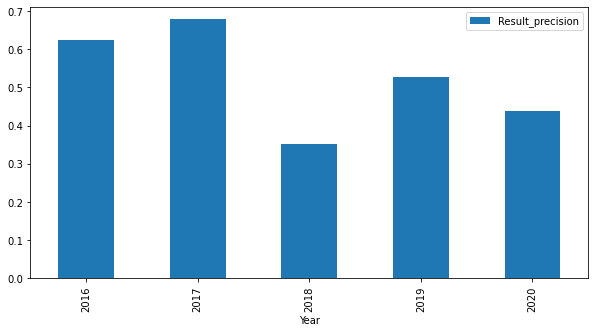

In [77]:
_ = df_construction[['Sector','Result_precision']].plot.bar(figsize=(10, 5))

### Energy

In [69]:
energy=sort_sector[5:10]

In [70]:
df_energy=energy.sort_values(by="Year")


In [71]:
df_energy.set_index('Year',inplace=True)
df_energy

,Sector,Result_precision
Year,,
2016,Energy,0.4826
2017,Energy,0.7306
2018,Energy,0.3655
2019,Energy,0.7638
2020,Energy,0.3795


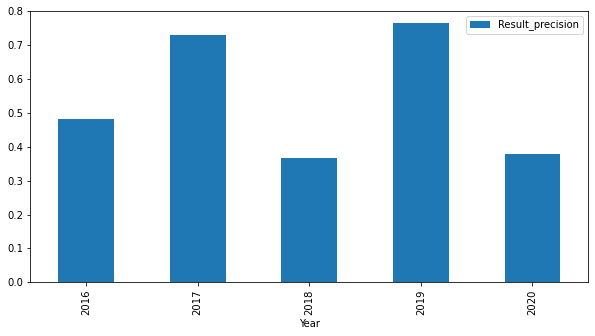

In [78]:
_ = df_energy[['Sector','Result_precision']].plot.bar(figsize=(10, 5))

### Healthcare

In [79]:
Healthcare=sort_sector[10:15]

In [80]:
df_Healthcare=Healthcare.sort_values(by="Year")

In [81]:
df_Healthcare.set_index('Year',inplace=True)
df_Healthcare

,Sector,Result_precision
Year,,
2016,Healthcare,0.6625
2017,Healthcare,0.6778
2018,Healthcare,0.4291
2019,Healthcare,0.5407
2020,Healthcare,0.6775


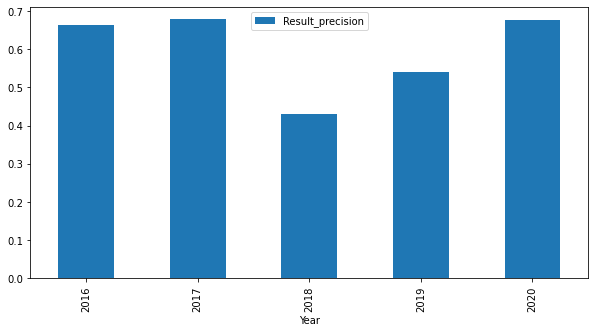

In [82]:
_ = df_Healthcare[['Sector','Result_precision']].plot.bar(figsize=(10, 5))

### Technology

In [85]:
Technology=sort_sector[15:20]
df_Technology=Technology.sort_values(by="Year")
df_Technology.set_index('Year',inplace=True)
df_Technology

,Sector,Result_precision
Year,,
2016,Technology,0.5915
2017,Technology,0.6229
2018,Technology,0.3924
2019,Technology,0.6176
2020,Technology,0.6251


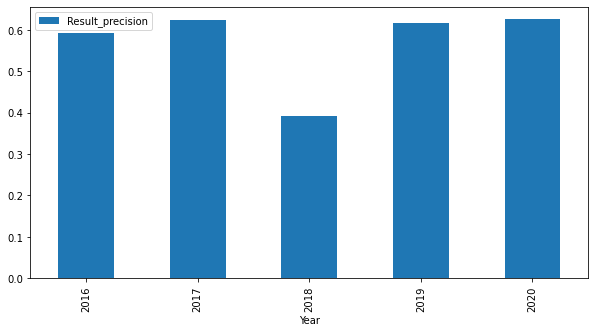

In [86]:
_ = df_Technology[['Sector','Result_precision']].plot.bar(figsize=(10, 5))

### Telecommunications & Media	

In [87]:
Media=sort_sector[20:25]
df_Media=Media.sort_values(by="Year")
df_Media.set_index('Year',inplace=True)
df_Media

,Sector,Result_precision
Year,,
2016,Telecommunications & Media,0.5851
2017,Telecommunications & Media,0.7156
2018,Telecommunications & Media,0.3526
2019,Telecommunications & Media,0.5730
2020,Telecommunications & Media,0.5683


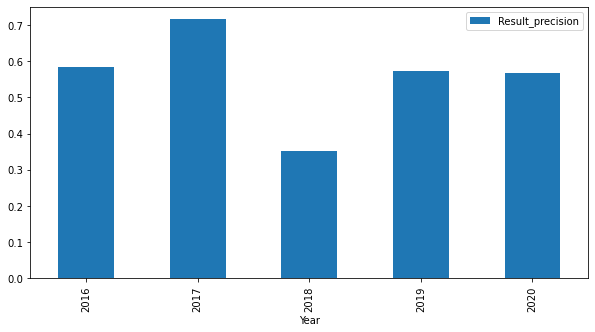

In [88]:
_ = df_Media[['Sector','Result_precision']].plot.bar(figsize=(10, 5))

### Utilities

In [90]:
Utilities=sort_sector[25:30]
df_Utilities=Utilities.sort_values(by="Year")
df_Utilities.set_index('Year',inplace=True)
df_Utilities

,Sector,Result_precision
Year,,
2016,Utilities,0.5056
2017,Utilities,0.5264
2018,Utilities,0.4278
2019,Utilities,0.5333
2020,Utilities,0.5223


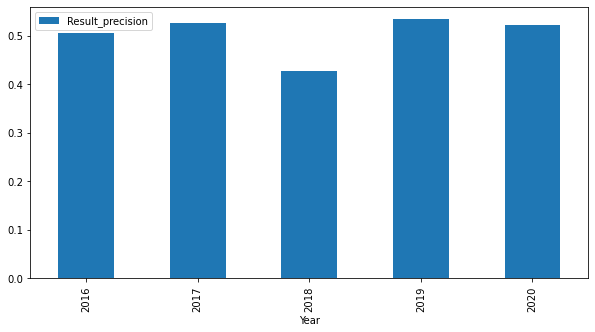

In [91]:
_ = df_Utilities[['Sector','Result_precision']].plot.bar(figsize=(10, 5))

In [97]:
df_precision.sort_values(by="Sector")

,Sector,Result_precision,Year
29,Construction,0.4387,2020
23,Construction,0.5279,2019
5,Construction,0.6246,2016
17,Construction,0.3525,2018
11,Construction,0.6779,2017
22,Energy,0.7638,2019
4,Energy,0.4826,2016
16,Energy,0.3655,2018
28,Energy,0.3795,2020
10,Energy,0.7306,2017


### All sector yearly

Healthcare:


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Public\Documents\anaconda\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Public\Documents\anaconda\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Public\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` par

Overall Train accuracy is: 0.9849984431464626
Overall Test accuracy is: 0.5028
Overall Test precision is: 0.4291
############################## DONE #################################
Telecommunications & Media:


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Public\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Overall Train accuracy is: 0.9816639956298397
Overall Test accuracy is: 0.5402
Overall Test precision is: 0.3526
############################## DONE #################################
Technology:


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.915127017648723
Overall Test accuracy is: 0.5046
Overall Test precision is: 0.3924
############################## DONE #################################
Utilities:


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Public\Documents\anaconda\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Public\Documents\anaconda\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\Public\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` par

Overall Train accuracy is: 0.9928430195760747
Overall Test accuracy is: 0.5412
Overall Test precision is: 0.4278
############################## DONE #################################
Energy:


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Public\Documents\anaconda\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Public\Documents\anaconda\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\Public\Documents\anaconda\lib\site-packages\numpy\core\_methods.py:170: RuntimeWa

Overall Train accuracy is: 0.9737899362962876
Overall Test accuracy is: 0.4386
Overall Test precision is: 0.3655
############################## DONE #################################
Construction:


C:\Users\Public\Documents\anaconda\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Overall Train accuracy is: 0.9287781099184059
Overall Test accuracy is: 0.4723
Overall Test precision is: 0.3525
############################## DONE #################################


<BarContainer object of 6 artists>

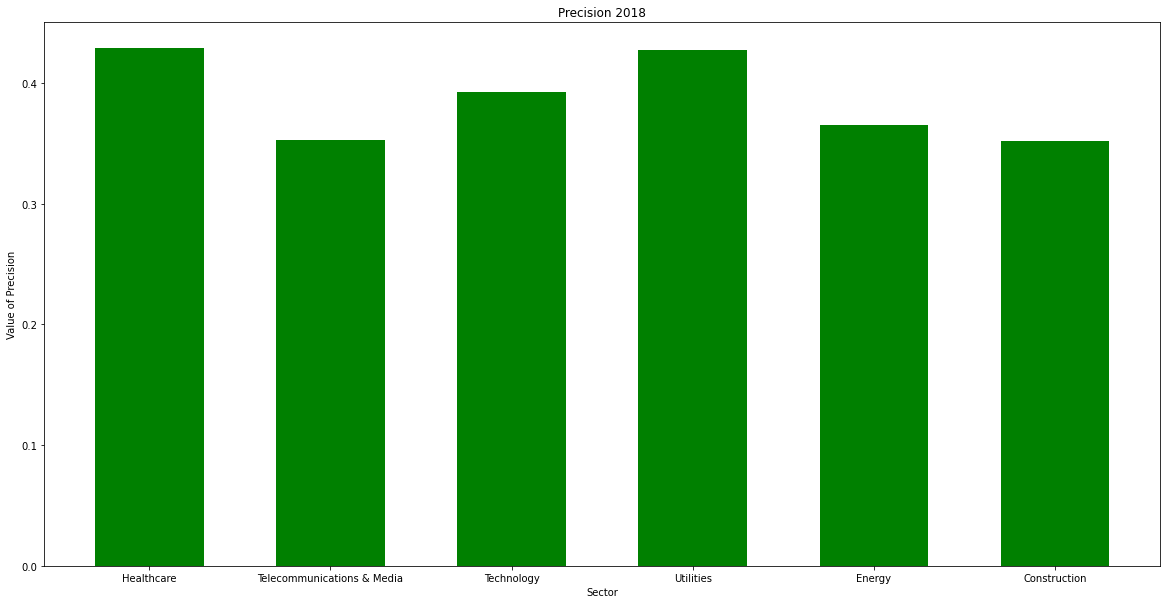

In [93]:
sectors=['Healthcare',
         'Telecommunications & Media',
         'Technology',
         'Utilities',
        'Energy',
        'Construction'
]

save=[]
name_sector=[]
for sector in sectors:
    wl = sector_filter(sector)
    print(f"{sector}:")
    X,y,df_all,avg_3,start_y= precision(wl,start_year=2018)
    save.append(avg_3)
    name_sector.append(sector)
    print('############################## DONE #################################')



plt.figure(figsize=(20,10))
plt.title('Precision {}'.format(start_y))
plt.xlabel('Sector')
plt.ylabel('Value of Precision')

plt.bar(name_sector,save,0.6,color='g')